In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import Iterator,load_img
from keras import layers
from keras import models
from keras import optimizers
from skimage import img_as_float
from skimage import io
import math 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# iterador 
class ValIterator(Iterator):
    """Class to iterate A and B images at the same time."""

    def __init__(
                 self, 
                 dir_dataset, 
                 csv_v_filename_prefix = "Fovea_locations_v.csv", 
                 dir_Validation ="Validation", 
                 dir_Glaucoma = "Glaucoma",
                 dir_NonGlaucoma = "Non-Glaucoma",
                 target_size=(150,150),
                 batch_size=32, 
                 shuffle=True, 
                 seed = None
                ):
        
        self.target_size=target_size
        
        # Carrega nome ficheiros das imagens de retina
        ## Validation
        self.path_Validation = os.path.join(dir_dataset, dir_Validation)
        
        self.ficheiros_Validation = set(x for x in os.listdir(self.path_Validation))
        print ("Numero de ficheiros Validation:", len(self.ficheiros_Validation))
        
        self.n=len(self.ficheiros_Validation)
            
        self.a_fnames = sorted(os.listdir(self.path_Validation))
        
        self.filenames=list(self.ficheiros_Validation)

        # Carega ficheiro CSV com posicao da Fove
        ## Validation
        
        path_csv_v = os.path.join(dir_dataset, csv_v_filename_prefix)

        self.data_Validation = pd.read_csv(path_csv_v)
        
        self.Fovea_X_Validation=self.data_Validation.iloc[:,3]
        self.Fovea_Y_Validation=self.data_Validation.iloc[:,4]
        
        self.img_shape_a = self._get_img_shape(self.target_size, 1)
        self.img_shape_b = self._get_img_shape(self.target_size, 1)
        
        
        super(ValIterator, self).__init__(len(self.a_fnames), batch_size,
                                               shuffle, seed)
     
    def load_imgs(self, idx):
        """Get a pair of images with index idx."""
        a_fname = self.filenames[idx]

        a = load_img(os.path.join(self.path_Validation, a_fname),
                     grayscale=True,
                     target_size=self.target_size)
        
        a = np.array(a)
  
        if(len(a.shape)<3):
            a = a.reshape(self.img_shape_a)

        return a
            
    def _get_img_shape(self, size, ch=1):

        img_shape = size + (ch,)
    
        return img_shape
    
    def load_to_mem(self):
        """Load images to memory."""
        self.a = np.zeros((self.N,) + self.img_shape_a)

        for idx in range(self.N):
            ai = self.load_imgs(idx)
            self.a[idx] = ai  
    
    def next(self):
        """Get the next pair of the sequence."""

        # Lock the iterator when the index is changed.
        with self.lock:
            index_array = next(self.index_generator)    
        current_batch_size = len(index_array)
        
        #Cria as varaiveis batch
        batch_X = np.zeros((current_batch_size,) + self.img_shape_a)
        batch_Y = np.zeros((current_batch_size,2))
        
        
        
        # precorre as 32 imagens do indice selecionadas i - orderm j - imagem
        for i, j in enumerate(index_array):
            a_img= self.load_imgs(j)
            #if(np.max(batch_X)>1.):
                #a_img=a_img/255.
            self.Fovea_X_Validation[j]=self.Fovea_X_Validation[j]*150/1634
            self.Fovea_Y_Validation[j]=self.Fovea_Y_Validation[j]*150/1634
            batch_X[i] = a_img
            batch_Y[i] = np.array([self.Fovea_X_Validation[j], 
                                   self.Fovea_Y_Validation[j]])
 
        
#        batch_X=batch_X/255.
#        batch_Y=batch_Y-np.mean(batch_Y)/np.std(batch_Y)
#        batch_c=batch_c-np.mean(batch_c)/np.std(batch_c)
        return [batch_X,batch_Y]

# ============================================================================
# ============================================================================
#   
# ============================================================================
    def generator(self):
        while 1:
            x,y = self.next()
            #print x.shape,y.shape
            x=x/255
            yield x,y

In [3]:
class TrainIterator(Iterator):
    """Class to iterate A and B images at the same time."""

    def __init__(
                 self, 
                 dir_dataset, 
                 csv_t_filename_prefix = "Fovea_locations_t.csv", 
                 dir_Validation ="Validation", 
                 dir_Training = "Training",
                 dir_Glaucoma = "Glaucoma",
                 dir_NonGlaucoma = "Non-Glaucoma",
                 target_size=(150,150),
                 batch_size=32, 
                 shuffle=True, 
                 seed = None
                ):
    
        
        self.target_size=target_size
        

        ## Training
        self.path_Training = os.path.join(dir_dataset, dir_Training)
        
        self.ficheiros_Training = set(x for x in os.listdir(self.path_Training))
        print ("Numero de ficheiros Training:", len(self.ficheiros_Training))
        
        self.n=len(self.ficheiros_Training)
        
        self.a_fnames = sorted(os.listdir(self.path_Training))

        self.filenames=list(self.ficheiros_Training)       
        # Carega ficheiro CSV com posicao da Fove
        ## Validation
        
        
        ## Training
        
        path_csv_t = os.path.join(dir_dataset,csv_t_filename_prefix)

        self.data_Training = pd.read_csv(path_csv_t)
        
        self.Fovea_X_Training=self.data_Training.iloc[:,2]
        self.Fovea_Y_Training=self.data_Training.iloc[:,3]
        
        self.img_shape_a = self._get_img_shape(self.target_size, 1)
        self.img_shape_b = self._get_img_shape(self.target_size, 1)
        
        super(TrainIterator, self).__init__(len(self.a_fnames), batch_size,
                                               shuffle, seed)
        
    def _get_img_shape(self, size, ch=1):

        img_shape = size + (ch,)
    
        return img_shape
    
    def load_imgs(self, idx):
        """Get a pair of images with index idx."""
        a_fname = self.filenames[idx]

        a = load_img(os.path.join(self.path_Training, a_fname),
                     grayscale=True,
                     target_size=self.target_size)
        
        a = np.array(a)
  
        if(len(a.shape)<3):
            a = a.reshape(self.img_shape_a)

        return a
            

    
    def load_to_mem(self):
        """Load images to memory."""
        self.a = np.zeros((self.N,) + self.img_shape_a)
    
        for idx in range(self.N):
            ai = self.load_imgs(idx)
            self.a[idx] = ai 


    def next(self):
        """Get the next pair of the sequence."""

        # Lock the iterator when the index is changed.
        #lock = threading.Lock()
        #with lock:
        index_array = next(self.index_generator)    
        current_batch_size = len(index_array)

      
        #Cria as varaiveis batch
        batch_X = np.zeros((current_batch_size,) + self.img_shape_a)
        batch_Y = np.zeros((current_batch_size,2))
        

        for i, j in enumerate(index_array):
            a_img= self.load_imgs(j)
            #if(np.max(batch_a)>1.):
                #a_img=a_img/255.
            self.Fovea_X_Training[j]=self.Fovea_X_Training[j]*150/2124
            self.Fovea_Y_Training[j]=self.Fovea_Y_Training[j]*150/2056
            batch_X[i] = a_img
            batch_Y[i] = np.array([self.Fovea_X_Training[j], 
                                   self.Fovea_Y_Training[j]])
 
        
        return [batch_X,batch_Y]

    def generator(self):
        while 1:
            x,y = self.next()
            x=x/255
            #print x.shape,y.shape
            yield x,y
            

In [4]:
val_it   = ValIterator(dir_dataset = r'C:\Users\Admin\Desktop\projeto\DataSet')

Numero de ficheiros Validation: 400


C:\Users\Admin\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


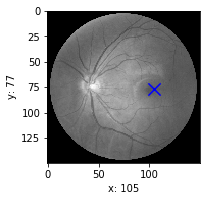

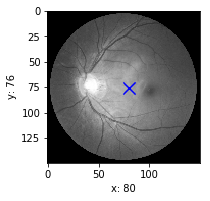

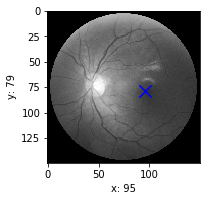

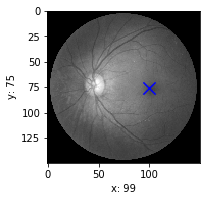

In [5]:
# Generator image_number 
image_number  = 4
 
i = 0
for batch in val_it:
    #print("len(batch): ", len(batch))
   
    imagem =batch[0][0][:,:,0]
    #print("imagem: ", imagem.shape)
    
    x = batch[1][0][0]
    x_trun=math.floor(x)
    
    y = batch[1][1][1]
    y_trun=math.floor(y)

        
    f = plt.figure(i)
    
    f = plt.subplot(1,2,1)
    f=plt.xlabel("x: " + str(x_trun))
    f=plt.ylabel("y: "+ str(y_trun))
#    print('x: ',x)
#    print('y: ',y)
    plt.scatter(x, y, s=150,marker='x',c='b')
    plt.imshow(imagem, cmap='gray')
    
    i += 1
    if i % image_number  == 0:
        # It will loop indefinitely, so we need to `break` the loop at some point!
        break

plt.show()

In [6]:
train_it   = TrainIterator(dir_dataset = r'C:\Users\Admin\Desktop\projeto\DataSet')

Numero de ficheiros Training: 400


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


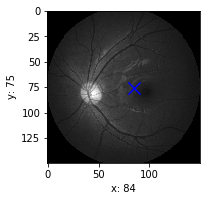

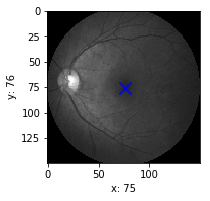

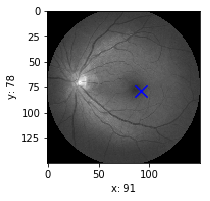

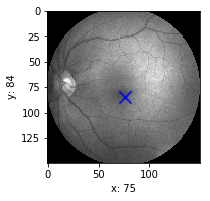

In [7]:
# Generator image_number 
image_number  = 4
 
i = 0
for batch in train_it:
    #print("len(batch): ", len(batch))
   
    imagem =batch[0][0][:,:,0]
    #print("imagem: ", imagem.shape)
    
    x = batch[1][0][0]
    x_trun=math.floor(x)
    
    y = batch[1][1][1]
    y_trun=math.floor(y)

        
    f = plt.figure(i)
    
    f = plt.subplot(1,2,1)
    f=plt.xlabel("x: " + str(x_trun))
    f=plt.ylabel("y: "+ str(y_trun))
#    print('x: ',x)
#    print('y: ',y)
    plt.scatter(x, y, s=150,marker='x',c='b')
    plt.imshow(imagem, cmap='gray')
    
    i += 1
    if i % image_number  == 0:
        # It will loop indefinitely, so we need to `break` the loop at some point!
        break

plt.show()

In [ ]:
from keras.layers import Input,Dense,Flatten,MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

import numpy as np
from keras import regularizers

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 34, 34, 64)        256       
__________

In [ ]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])
#em duvida se vou colocar mae

In [ ]:
history=model.fit_generator(train_it.generator(),
      steps_per_epoch=20,
      epochs=1,
      validation_data=val_it.generator(),
      validation_steps=20)

mae_history = history.history['mean_absolute_error']
all_mae_histories.append(mae_history)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

 4/20 [=====>........................] - ETA: 5:32 - loss: 6273.7872 - mean_absolute_error: 78.9900

In [ ]:
model.save('primeiro_modelo.h5')

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score